# Malaria Detection with Raspberry Pi Zero 2W

## Objectives:

Automating the process of detecting Malaria with deep learning aims to provide a rapid, accurate, and accessible diagnostic tool. This technological leap would enable quicker treatment, reduce the burden on healthcare systems, and improve patient outcomes, ultimately saving countless lives by making early and reliable diagnosis available to even the most remote and underserved populations.

## Important Considerations:

- This is just a Proof of Concept project, it needs to be adapted to a specific microscope to work properly.
- It is important to make this product as cheap as possible since Malaria affects mostly under developed countries.
- We need a way to pre-process our data in order to use it as input to the model.

## Imports:

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix
import glob

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Dataset:

### Description:

The dataset that was used was: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

There are a total of 27560 images (colored) that we have taken from microscopic images. These images are of the following categories:

- Parasitized: The parasitized cells contain the Plasmodium parasite which causes malaria
- Uninfected: The uninfected cells are free of the Plasmodium parasites

### Download the Dataset:

In [4]:
try:
    dataset_path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

except Exception as e:
    print(f"Falha ao baixar o dataset: {e}")

In [5]:
print(dataset_path)

/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


### Preparing the Dataset:

In [6]:
for i in os.listdir(os.path.join(dataset_path, 'cell_images')):
    print(i)

cell_images
Uninfected
Parasitized


In [7]:
parasitized_path = os.path.join(dataset_path, 'cell_images', 'Parasitized')
uninfected_path = os.path.join(dataset_path, 'cell_images', 'Uninfected')

In [8]:
len(os.listdir(parasitized_path)), len(os.listdir(uninfected_path))

(13780, 13780)

In [9]:
parasitized_files = glob.glob(os.path.join(parasitized_path, '*.png'))
uninfected_files = glob.glob(os.path.join(uninfected_path, '*.png'))

In [10]:
parasitized_files[:5]

['/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C129P90ThinF_IMG_20151004_133538_cell_75.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C68P29N_ThinF_IMG_20150819_134625_cell_50.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C174P135NThinF_IMG_20151127_135342_cell_221.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C49P10thinF_IMG_20150724_102843_cell_184.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C48P9thinF_IMG_20150721_164129_cell_11.png']

In [11]:
uninfected_files[:5]

['/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C121P82ThinF_IMG_20151002_133540_cell_78.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C95P56ThinF_IMG_20150821_171701_cell_88.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C55P16thinF_IMG_20150728_123237_cell_1.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C104P65ThinF_IMG_20150918_172053_cell_114.png',
 '/home/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C175P136NThinF_IMG_20151127_141428_cell_161.png']

In [12]:
all_files = np.array((parasitized_files) + (uninfected_files))
all_labels = np.array(([1] * len(parasitized_files)) + ([0] * len(uninfected_files)))

In [13]:
seed = 42
rng = np.random.default_rng(seed)
indices = np.arange(len(all_files))
rng.shuffle(indices)

all_files = all_files[indices]
all_labels = all_labels[indices]

In [14]:
IMG_SIZE = (64, 64)

def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

In [15]:
total_samples = len(all_files)
train_size = 0.7
val_size = 0.1
test_size = 0.2

train_count = int(total_samples * train_size)
val_count = int(total_samples * val_size)
test_count = total_samples - train_count - val_count

train_files = all_files[:train_count]
train_labels = all_labels[:train_count]
val_files = all_files[train_count:train_count + val_count]
val_labels = all_labels[train_count:train_count + val_count]
test_files = all_files[train_count + val_count:]
test_labels = all_labels[train_count + val_count:]

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.map(
    load_and_preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.shuffle(buffer_size=1000)

val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_ds = val_ds.map(
    load_and_preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.shuffle(buffer_size=1000)

test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_ds = test_ds.map(
    load_and_preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.shuffle(buffer_size=1000)

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

In [19]:
BATCH_SIZE = 32

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    
    return ds.prefetch(buffer_size = tf.data.AUTOTUNE)

def prepare_for_evaluation(ds):
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_evaluation(val_ds)
test_ds = prepare_for_evaluation(test_ds)

## Visualizing the Data:

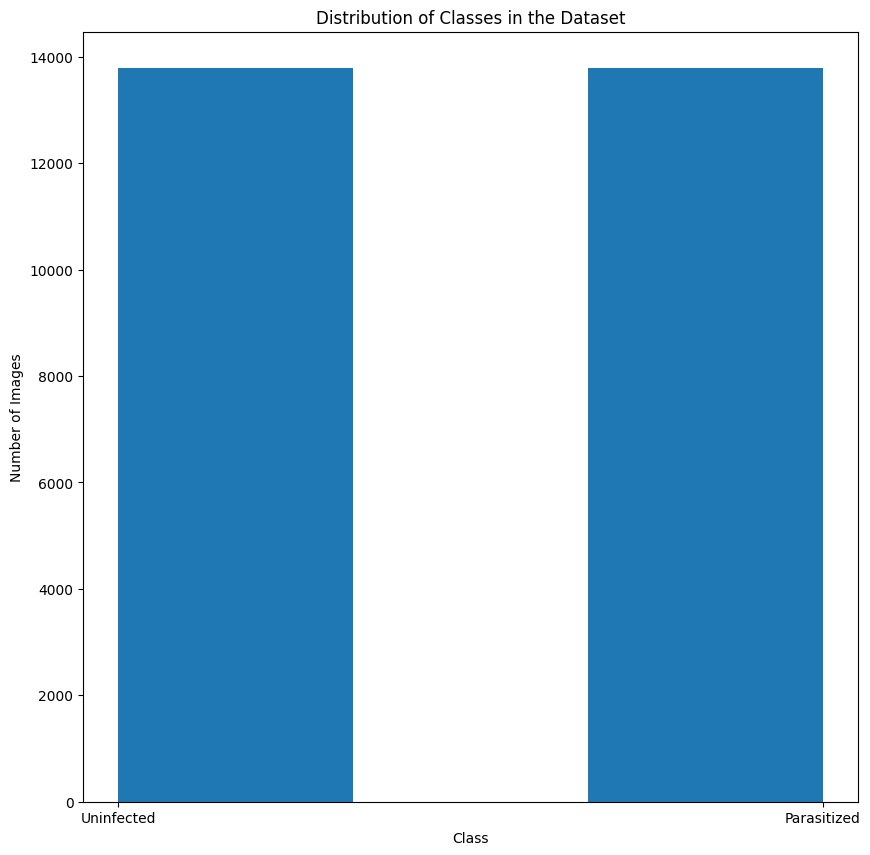

In [21]:
plt.figure(figsize=(10, 10))
plt.hist(all_labels, bins=3)
plt.xticks([0, 1], ['Uninfected', 'Parasitized'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Dataset')
plt.show()

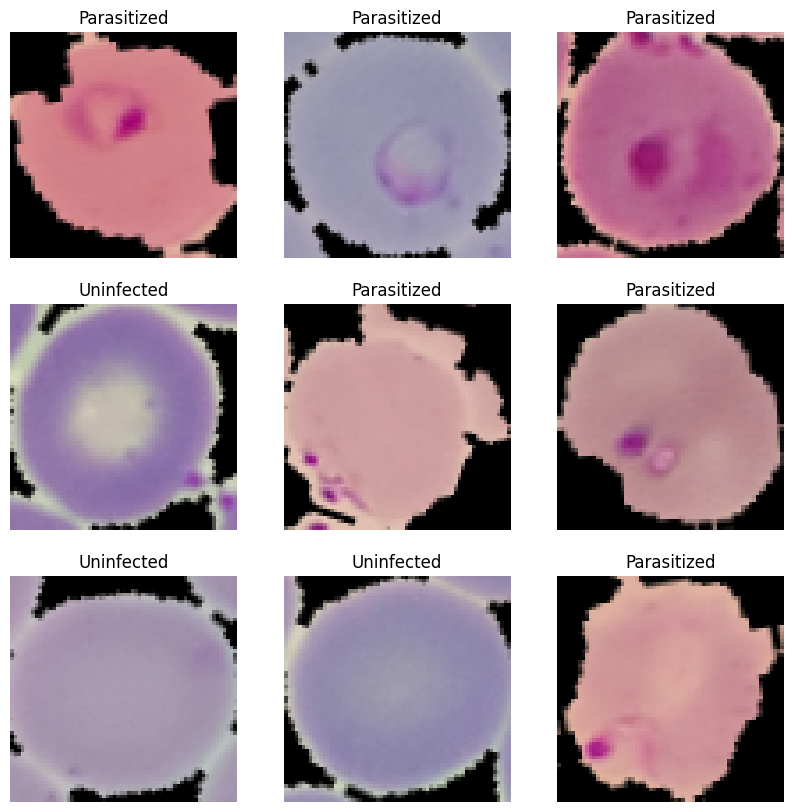

2025-12-03 18:54:25.979547: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Parasitized" if labels[i].numpy() == 1 else "Uninfected")
        plt.axis("off")
    plt.show()

## Training:

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((64, 64, 3)),

    # Conv 1:
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    # Conv 2:
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    # Conv 3:
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,521 (2.64 MB)

 Trainable params: 691,521 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/model.keras', save_best_only=True, monitor='val_loss')
]

In [27]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)

Epoch 1/100


2025-12-03 18:54:34.632889: I external/local_xla/xla/service/service.cc:163] XLA service 0x73823c00ebd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 18:54:34.632907: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-12-03 18:54:34.658891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 18:54:34.815575: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-03 18:54:34.950294: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 18:54:34.950342: I e

 64/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4792 - loss: 0.7162

I0000 00:00:1764798877.874723  180650 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


602/603 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6190 - loss: 0.6143

2025-12-03 18:54:39.483541: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 18:54:39.799062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1866', 28 bytes spill stores, 28 bytes spill loads

2025-12-03 18:54:39.841472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1866', 24 bytes spill stores, 24 bytes spill loads



603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6192 - loss: 0.6141

2025-12-03 18:54:42.140959: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 18:54:42.395247: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_107', 100 bytes spill stores, 100 bytes spill loads



603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7691 - loss: 0.4528 - val_accuracy: 0.9419 - val_loss: 0.1875 - learning_rate: 0.0010
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9408 - loss: 0.1948 - val_accuracy: 0.9488 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9465 - loss: 0.1735 - val_accuracy: 0.9463 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9495 - loss: 0.1694 - val_accuracy: 0.9514 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9517 - loss: 0.1632 - val_accuracy: 0.9510 - val_loss: 0.1647 - learning_rate: 0.0010
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9502 - loss: 0.1605 - val_accuracy: 0.9488 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9523 - loss: 0.1580 - val_a

## Testing:

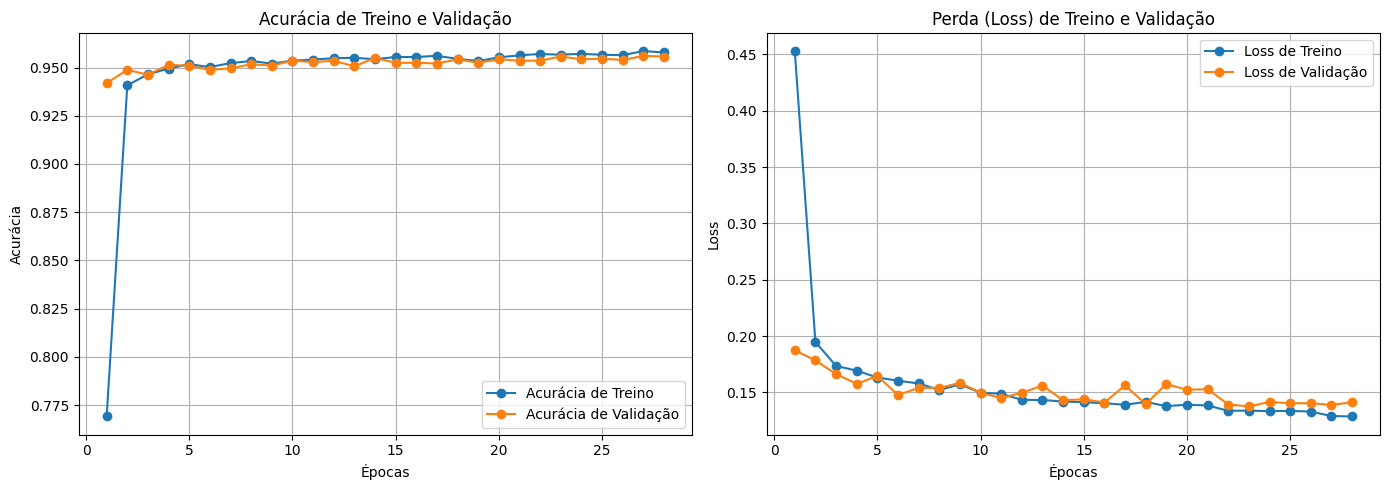

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'o-', label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, 'o-', label='Acurácia de Validação')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'o-', label='Loss de Treino')
plt.plot(epochs_range, val_loss, 'o-', label='Loss de Validação')
plt.title('Perda (Loss) de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [29]:
model.evaluate(test_ds)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9606 - loss: 0.1202


[0.12024065107107162, 0.9606384634971619]

In [30]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2788
           1       0.98      0.94      0.96      2725

    accuracy                           0.96      5513
   macro avg       0.96      0.96      0.96      5513
weighted avg       0.96      0.96      0.96      5513



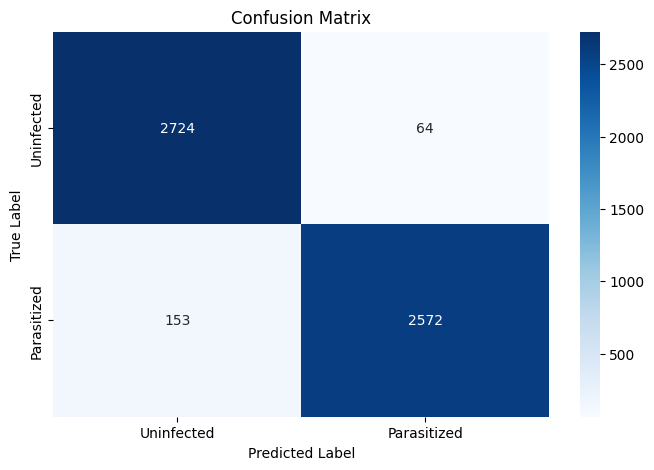

In [32]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Convert to TFLite:

### Não Quantizado:

In [33]:
model_path = '../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/model.keras'
tflite_path = '../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/model.tflite'

model = tf.keras.models.load_model(model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

print("Convertendo para TFLite...")
tflite_model = converter.convert()

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Modelo salvo em: {tflite_path}")

Convertendo para TFLite...
INFO:tensorflow:Assets written to: /tmp/tmpja1y83tx/assets


INFO:tensorflow:Assets written to: /tmp/tmpja1y83tx/assets


Saved artifact at '/tmp/tmpja1y83tx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  127007287301696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007287306624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285310416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285310240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285377008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285368736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285586128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285586832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285590880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285808816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007285819376

W0000 00:00:1764798951.798329  180511 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764798951.798346  180511 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-03 18:55:51.798604: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpja1y83tx
2025-12-03 18:55:51.799063: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-03 18:55:51.799068: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpja1y83tx
I0000 00:00:1764798951.803036  180511 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-03 18:55:51.803726: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-03 18:55:51.830620: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpja1y83tx
2025-12-03 18:55:51.837324: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [34]:
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n--- Detalhes do Modelo TFLite ---")
print("Input shape:", input_details[0]['shape'])
print("Input type:", input_details[0]['dtype'])
print("Output shape:", output_details[0]['shape'])


--- Detalhes do Modelo TFLite ---
Input shape: [ 1 64 64  3]
Input type: <class 'numpy.float32'>
Output shape: [1 1]


/home/rolds/Documents/venvs/tensorflow_venv/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [35]:
y_true = []
y_pred = []

input_index = input_details[0]['index']
output_index = output_details[0]['index']

print("Iniciando inferência no dataset de teste...")

for image, label in (test_ds.unbatch()):
    img_input = np.expand_dims(image.numpy(), axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, img_input)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    
    prediction = 1 if output[0][0] > 0.5 else 0
    
    y_pred.append(prediction)
    true_label = label.numpy()
    if np.ndim(true_label) > 0 and len(true_label) > 1: # É one-hot
        y_true.append(np.argmax(true_label))
    else: # É inteiro
        y_true.append(int(true_label))


Iniciando inferência no dataset de teste...


2025-12-03 18:56:00.410312: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
print("\n--- Classification Report ---")

print(classification_report(y_true, y_pred, target_names=['Classe 0', 'Classe 1']))


--- Classification Report ---
              precision    recall  f1-score   support

    Classe 0       0.95      0.98      0.96      2788
    Classe 1       0.98      0.94      0.96      2725

    accuracy                           0.96      5513
   macro avg       0.96      0.96      0.96      5513
weighted avg       0.96      0.96      0.96      5513



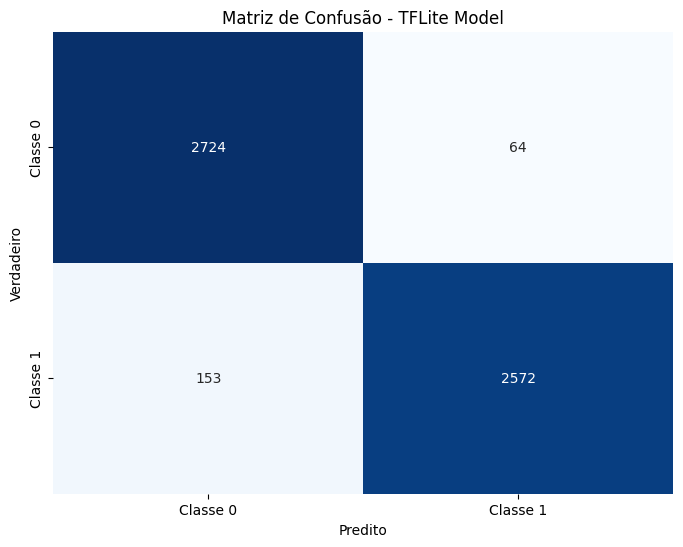

In [37]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - TFLite Model')
plt.show()

### Quantizado:

In [38]:
model_path = '../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/model.keras'
tflite_path_quant = '../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/model_int8.tflite'

model = tf.keras.models.load_model(model_path)

def representative_data_gen():
    for image, label in test_ds.unbatch().take(100):
        image = tf.expand_dims(image, 0)
        image = tf.cast(image, tf.float32)
        yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model_quant = converter.convert()

with open(tflite_path_quant, 'wb') as f:
    f.write(tflite_model_quant)
print(f"Modelo quantizado salvo em: {tflite_path_quant}")

INFO:tensorflow:Assets written to: /tmp/tmpsf882dqk/assets


INFO:tensorflow:Assets written to: /tmp/tmpsf882dqk/assets


Saved artifact at '/tmp/tmpsf882dqk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  127006618850176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127006618855104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127006618972432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127006618972256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007287299056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007287303632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007284755296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007284601856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127007284596048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127006619095056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127006619100336

/home/rolds/Documents/venvs/tensorflow_venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764799247.255999  180511 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764799247.256009  180511 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-03 19:00:47.256087: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsf882dqk
2025-12-03 19:00:47.256430: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-03 19:00:47.256433: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpsf882dqk
2025-12-03 19:00:47.259306: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-03 19:00:47.281447: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bund

Modelo quantizado salvo em: ../Projects/Malaria-Detection-on-Raspberry-Pi-Zero-2W/models/model_int8.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32
2025-12-03 19:00:47.560491: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.


In [39]:
interpreter = tf.lite.Interpreter(model_path=tflite_path_quant)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n--- Detalhes do Modelo TFLite ---")
print("Input shape:", input_details[0]['shape'])
print("Input type:", input_details[0]['dtype'])
print("Output shape:", output_details[0]['shape'])


--- Detalhes do Modelo TFLite ---
Input shape: [ 1 64 64  3]
Input type: <class 'numpy.float32'>
Output shape: [1 1]


/home/rolds/Documents/venvs/tensorflow_venv/lib/python3.10/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [40]:
y_true = []
y_pred = []

input_index = input_details[0]['index']
output_index = output_details[0]['index']

for image, label in (test_ds.unbatch()):
    img_input = np.expand_dims(image.numpy(), axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, img_input)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    
    prediction = 1 if output[0][0] > 0.5 else 0
    
    y_pred.append(prediction)
    true_label = label.numpy()
    if np.ndim(true_label) > 0 and len(true_label) > 1:
        y_true.append(np.argmax(true_label))
    else:
        y_true.append(int(true_label))


In [41]:
print("\n--- Classification Report ---")

print(classification_report(y_true, y_pred, target_names=['Classe 0', 'Classe 1']))


--- Classification Report ---
              precision    recall  f1-score   support

    Classe 0       0.95      0.98      0.96      2788
    Classe 1       0.98      0.94      0.96      2725

    accuracy                           0.96      5513
   macro avg       0.96      0.96      0.96      5513
weighted avg       0.96      0.96      0.96      5513



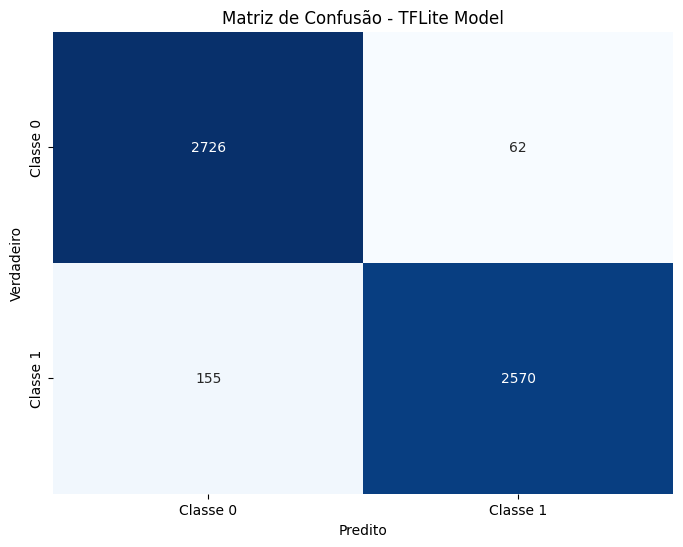

In [42]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - TFLite Model')
plt.show()